# Timoshenko Beam
## Test and Hypersolver Pre-training

In [1]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn.numerics import odeint, Euler, HyperEuler

In [2]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append(2*'../') # go n dirs back
from src import *
from dicts import *
from timoshenko_utils import *

In [3]:
# Change device according to your configuration
# device = torch.bdevice('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

In [10]:


# Load discretization data
A = torch.load('A_sys').to(device).float()
B = torch.load('B_sys').to(device).float()
x0 = torch.load('x0')[None].to(device).float()
x_dim, u_dim = x0.shape[1], 2

u = RandConstController((1, u_dim), -1, 1)

f = TimoshenkoBeam(A, B, u).to(device)
print(f.u(0,x0).shape)

torch.Size([1, 2])


## Training with randomized trajectory generation (random walks)

We generate initial positions by random propagation of the initial position over time:
1. Start with a batch of the same initial conditions
2. Generate batched random controllers
3. Propagate them forward by a random time 
4. Add the new positions to the positions batch via concatenation
5. Reiterate from 2) until the random time in 3) in more than $t_f$, final time to end the simulation

In [91]:
def random_walk(x0, dt, t0=0, tf=5, steps_min=1, steps_max=200,
                bs=64,
                solver='rk4'):
    '''
    We generate initial positions by random propagation of the initial position over time:
        1. Start with a batch of the same initial conditions
        2. Generate batched random controllers
        3. Propagate them forward by a random time 
        4. Add the new positions to the positions batch via concatenation
        5. Reiterate from 2) until the random time in 3) in more than $t_f$, final time to end the simulation
    '''
    t_checkpoint = 0
    x0_batch = x0.repeat(bs, 1, 1).to(device).squeeze(1)
    x0_checkpoint = x0_batch
    u_batch = None
    
    # End the simulation if it has reached the end time
    while t_checkpoint <= tf:
        # Random times
        tf_checkpoint = uniform(t_checkpoint+steps_min*dt, t_checkpoint+steps_max*dt) # number of steps for final checkpoint time
        steps = int((tf_checkpoint - t_checkpoint)/dt) + 1
        t = torch.linspace(t_checkpoint, tf_checkpoint, steps)

        # Generate intial states with random controllers
        u_rand.u0 = u_dist.sample((bs,))
        f.u = u_rand
        
        # Random walk
        x0_checkpoint = odeint(f, x0_checkpoint, t, solver=solver)[1][-1]
        
        # Add the initial positions and to the batch
        x0_batch = torch.cat([x0_batch, x0_checkpoint], dim=0)
        
        # Increase time 
        t_checkpoint = tf_checkpoint
        
    return x0_batch

## Snake

In [193]:
class HyperNet(nn.Module):
    """Simple hypernetwork for controlled systems
    Input: current x, f and u from the controlled system
    Output: p-th order residuals"""
    def __init__(self, net):
        super().__init__()
        self.net = net
        
    def forward(self, t, x):
        xfu = torch.cat([x, f.cur_f, f.cur_u], -1)
        return self.net(xfu)

indim = x_dim * 2 + u_dim
hdim = 256
outdim = x_dim
snake_activation = Snake(hdim)

net = nn.Sequential(nn.Linear(indim, hdim),
                    snake_activation,
                    nn.Linear(hdim, hdim),
                    snake_activation,
                    nn.Linear(hdim, outdim))

hypersolver = HyperEuler(HyperNet(net))

### Parameters

# TODO

In [316]:
u_low = torch.Tensor([-1, -1]).to(device)
u_high = torch.Tensor([1, 1]).to(device)
u_dist = torch.distributions.Uniform(u_low, u_high)
x0_batch = x0.repeat(bs, 1, 1).to(device).squeeze(1)
u_rand = RandConstController()

# Stepping
t0, dt = 0, 0.005
tf = 3.5
steps_min = 1
steps_max = 1000
reset_rw = 100 # when to reset the random walk

# Training
lr = 1e-3
epochs = 50000
bs = 128
opt = torch.optim.Adam(hypersolver.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[3e5, 4e5], gamma=0.1)

### Training loop

In [317]:
from tqdm import trange
from numpy.random import uniform

loss_func = nn.MSELoss()
hypernet = hypersolver.hypernet
span = torch.linspace(0, dt, 2)
losses = []


with trange(0, epochs, desc="Epochs") as stepx:
    for i in stepx:    
        
        # Repeat random walk every n epochs
        if i % reset_rw == 0:
            # Random walk
            x0_rand_walk = random_walk(x0, dt, bs=bs, steps_max=steps_max)
        
        # Draw controllers from distribution with random walk's batch size
        f.u.u0 = u_dist.sample((x0_rand_walk.shape[0],))

         # Compute residuals
        sol_gt = odeint(f, x0_rand_walk, span, solver='tsit5', atol=1e-5, rtol=1e-5)[1][-1]
        sol = x0_rand_walk + f(0., x0_rand_walk)*dt
        residuals = (sol_gt - sol) / dt**2
        residuals_hypersolver = hypernet(0., x0_rand_walk) # SIREN SPECIFIC
        loss = loss_func(residuals, residuals_hypersolver)
        
        # Optimization step
        loss.backward(); opt.step(); opt.zero_grad(); scheduler.step()
        loss_val = loss.detach().cpu().item()
        stepx.set_postfix({'Loss':loss_val})
        losses.append(loss_val)

Epochs:  81%|████████  | 40572/50000 [30:02<06:58, 22.51it/s, Loss=4.01]     


KeyboardInterrupt: 

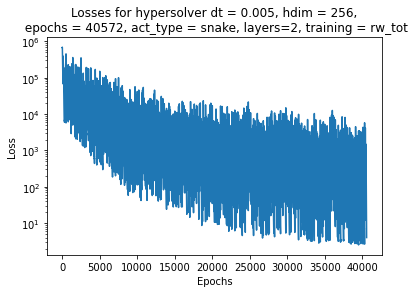

In [318]:
import datetime

plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses for hypersolver dt = ' + str(dt)
          + ', hdim = ' + str(hdim)
          + ',\n epochs = '+ str(i) 
          + ', act_type = snake, layers=2, training = rw_tot')

filename = 'losses_' +  str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")) + '.jpg'
plt.savefig('media/losses/'+filename)

In [319]:
u_low = torch.Tensor([-1, -1]).to(device)
u_high = torch.Tensor([1, 1]).to(device)
u_dist = torch.distributions.Uniform(u_low, u_high)
f.u = RandConstController()

f.u.u0 = u_dist.sample((1,)) # set random controller for everyone
t0, tf, dt = 0, 3, 0.005
steps = int((tf - t0)/dt) + 1
t = torch.linspace(t0, tf, steps)

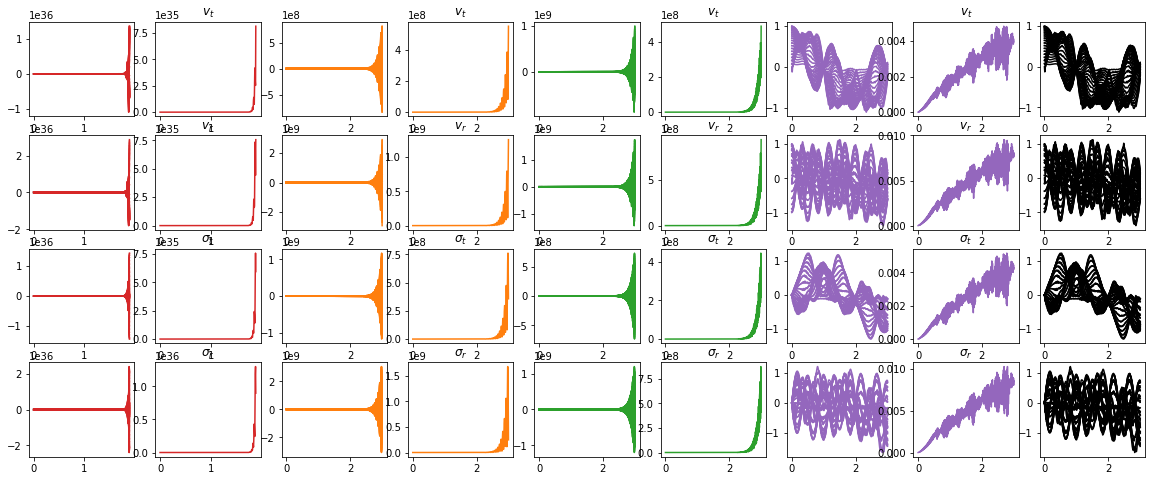

In [320]:
plot_test(f, x0, t, hypersolver)

In [ ]:
torch.save(hypersolver, 'saved_models/hypersolver_'+str(dt)+'_'+str(hdim)+'_snake_rw_layers_2_new.pt')

___